In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
from statistics import mode

# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import cut_regrid_reynolds_sst,cut_process_sst_obs_trends,proc_landschutzer,process_co2_land_trends

In [6]:
# Set up the remote dask cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
#cluster.adapt(minimum=2, maximum=16)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.139:40219,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
#cluster.scale(cores=8)

In [ ]:
#Bring all the unit conversions here. 
cafe_co2_all=(xr.open_dataset('../processed_data/cafe/eqpac/stf10_ensmean_1982_all_ensembles.nc',chunks={'time':1}))#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_sst_all=xr.open_dataset('../processed_data/cafe/eqpac/sst_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})
cafe_co2_all_g=((cafe_co2_all/1000)*86400*-12) #g/m2/day
#cafe_co2_all_g


phy_mean=xr.open_dataset('../processed_data/cafe/eqpac/phy_ensmean_1982_15m_.nc')
#phy_std=xr.open_dataset('../processed_data/eqpac/surface_phy_ensstd_1982.nc')
phy_trend82=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_1982_15m_.nc')
phy_trend20=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_2000_15m_.nc')

#pprod_std=xr.open_dataset('../processed_data/eqpac/pprod_gross_2d_ensstd../_1982.nc')
pprod_mean=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_ensmean_1982.nc')
pprod_trend82=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_1982.nc')
pprod_trend20=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_2000.nc')


#LOAD CAFE SST AND CO2 FLUX
cafe_sst_std=xr.open_dataset('../processed_data/cafe/global/sst_ensstd_1982.nc')
cafe_sst_mean=xr.open_dataset('../processed_data/cafe/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_2000.nc')


cafe_co2_std=xr.open_dataset('../processed_data/cafe/global/stf10_ensstd_1982.nc')
cafe_co2_mean=xr.open_dataset('../processed_data/cafe/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_2000.nc')


#Load CO2 and SST OBS PRODUCTS
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2_82tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_1982.nc')
land_co2_20tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_2000.nc')

rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst_82tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.1982.nc')
rey_sst_20tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.2000.nc')

In [4]:
err=xr.open_dataset('../processed_data/err/CO2_flux_allerror.nc',chunks='auto')

In [13]:
cluster.scale(cores=6)

In [24]:
cluster

In [ ]:
co2_err_mean_over_time=xr.open_.to_netcdf('../processed_data/err/CO2_flux_meanerror.nc')
co2_err_all=xr.open_.to_netcdf('../processed_data/err/CO2_flux_allerror.nc')

In [ ]:
# Lets play, plot and check the error statistics.

In [29]:
regional_sst_err=xr.open_dataset('../processed_data/err/regional_sst_err.nc')
regional_err = xr.open_dataset('../processed_data/err/regional_co2_err.nc')

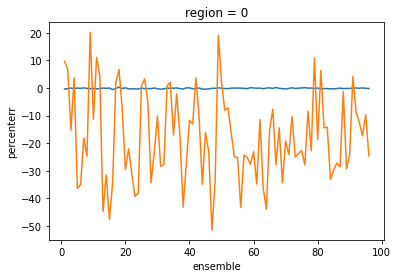

In [46]:

#plt.legend(['SST','CO2 flux'])

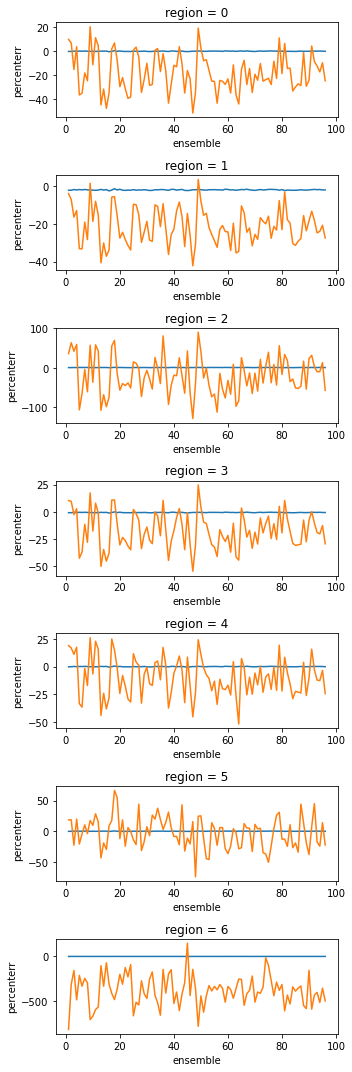

In [68]:
plt.figure(figsize=(5,15))
for region in [0,1,2,3,4,5,6]:
    plt.subplot(7,1,region+1)

    regional_sst_err.sel(region=region).percenterr.plot()
    regional_err.sel(region=region).percenterr.plot()
    
plt.tight_layout()

In [71]:
regional_err.sel(region=2)#.region_name

<xarray.Dataset>
Dimensions:      (ensemble: 96)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    region       int64 2
Data variables:
    percenterr   (ensemble) float64 35.88 63.54 41.62 ... -9.719 13.21 -56.69
    bias         (ensemble) float64 0.008628 0.0085 ... -0.0002268 -0.006896
    mae          (ensemble) float64 0.01911 0.01897 0.01865 ... 0.01579 0.01442
    region_name  object 'NorthEast EqPac'

Whole EqPac
[ 1  2  4 12 17 18 19 25 26 27 33 34 36 42 50 51 52 66 77 81 88 91 92 95]
SouthEast EqPac
[ 1  2  9 11 17 18 25 26 33 36 42 49 50 79 81]
NorthEast EqPac
[ 7 27 30 34 37 52 62 66 74 77 92 93 94]
All East EqPac
[ 2  3  4 11 12 25 26 27 33 34 41 42 45 50 51 65 66 72 75 79 82 88 90 91]
Central EqPac
[ 7 10 19 21 26 27 29 30 33 34 37 40 41 42 43 45 51 52 62 65 66 68 70 72
 74 75 77 81 82 88 92 95]
Dateline EqPac
[ 6  8 10 16 23 24 30 31 36 39 40 41 55 57 58 62 63 67 68 71 72 77 91]
FarWest EqPac
[74]
Seemingly, the most accurate ensemble member across the whole pacific could be: 26


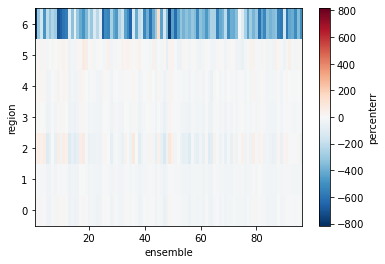

In [90]:
# CO2 Ensemble Members within 20% cutoff in the different Pacific Regions
err_cutoff=10
regional_err.percenterr.plot()
counter=[]
for region in [0,1,2,3,4,5,6]:
    dat=regional_err.sel(region=region)
    print(dat.region_name.values)
    dat=dat.percenterr
    if region==6:
        err_cutoff=20
    ensembles=(dat.where(((dat<err_cutoff)&(dat>-err_cutoff))).dropna(dim='ensemble').ensemble.values)
    print(ensembles)
    for i in ensembles:
        counter.append(i)
print('Seemingly, the most accurate ensemble member across the whole pacific could be: '+str(mode(counter)))

Whole EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
SouthEast EqPac
[]
NorthEast EqPac
[16 23 24 31 38 45 81 84]
All East EqPac
[ 3  5  7 13 15 18 20 25 35 36 39 40 43 49 50 53 54 55 56 59 60 65 67 72
 74 75 76 77 78 80 87 91 92 94]
Central EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Dateline EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 

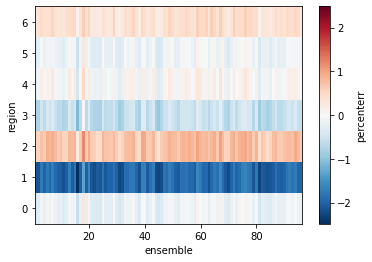

In [94]:
# CO2 Ensemble Members within 20% cutoff in the different Pacific Regions
err_cutoff=0.5
regional_sst_err.percenterr.plot()
counter=[]
for region in [0,1,2,3,4,5,6]:
    dat=regional_sst_err.sel(region=region)
    print(dat.region_name.values)
    dat=dat.percenterr
    #if region==6:
    #    err_cutoff=20
    ensembles=(dat.where(((dat<err_cutoff)&(dat>-err_cutoff))).dropna(dim='ensemble').ensemble.values)
    print(ensembles)
    for i in ensembles:
        counter.append(i)
print('Seemingly, the most accurate ensemble member across the whole pacific could be: '+str(mode(counter)))

Whole EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
SouthEast EqPac
[]
NorthEast EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
All East EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Central EqPac
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18

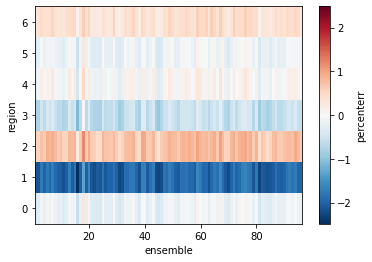

In [ ]:
# Ok so the Southeast Pacific has a ~ -2% SST bias, but the worst CO2 estimates are in the far west.